# Filtering and Restoring of Mixed and Noise Polluted Audio Samples Using Different Approaches

# 2. Independent Component Analysis (ICA)

## Load Edited Audio Samples

In [1]:
import os
import soundfile as sf
import numpy as np

inp_folder = 'audio_samples'
outp_folder = 'mixed_signals'
ica_folder = 'ica_samples'

In [2]:
file_names = ['speech.wav', 'street.wav', 'music.wav', 'white_noise.wav']

audio_speech, sr_speech = sf.read(os.path.join(inp_folder, file_names[0]))
audio_street, sr_street = sf.read(os.path.join(inp_folder, file_names[1]))
audio_music, sr_music = sf.read(os.path.join(inp_folder, file_names[2]))
audio_wnoise, sr_wnoise = sf.read(os.path.join(inp_folder, file_names[3]))

print("Array Type is: {}".format(audio_music.dtype))

audio_files = [audio_speech, audio_street, audio_music, audio_wnoise]
sample_rates = [sr_speech, sr_street, sr_music, sr_wnoise]
max_length = len(audio_files[0])

for name, sr, audio in zip(file_names, sample_rates, audio_files):
    print("File: {}, Sample Rate: {}, Samples: {}, Time: {}sec".format(name, sr, len(audio), len(audio)/sr))

Array Type is: float64
File: speech.wav, Sample Rate: 44100, Samples: 352800, Time: 8.0sec
File: street.wav, Sample Rate: 44100, Samples: 352800, Time: 8.0sec
File: music.wav, Sample Rate: 44100, Samples: 352800, Time: 8.0sec
File: white_noise.wav, Sample Rate: 44100, Samples: 352800, Time: 8.0sec


## ICA

ICA is a method for seperating a multivariate signal into components. 

Steps:

1. Center $\mathbf{d}$ by subtracting the mean
1. Whiten
1. Choose random initial value for the de-mixing matrix $\mathbf{W}$
1. Calculate the new value for $\mathbf{W}$
1. Normalize $\mathbf{W}$
1. Check whether algorithm has converged and if it hasn’t, return to step 4
1. Take the dot product of $\mathbf{W}$ and $\mathbf{d}$ to get the independent source signals
$$\mathbf{S} = \mathbf{W}\mathbf{d}$$

Source:
* [Independent Component Analysis (ICA) In Python, Cory Maklin](https://towardsdatascience.com/independent-component-analysis-ica-in-python-a0ef0db0955e)
* [Separating mixed signals with Independent Component Analysis, Carsten Klein](https://towardsdatascience.com/separating-mixed-signals-with-independent-component-analysis-38205188f2f4)

In [3]:
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA

np.random.seed(10)

### Build Observation using True Signals

Generating signals for observation #3 and apply to "cocktail party problem". 

One recording per existing signal is used here. The recorded signal contains a proportion of pollution caused by the other signals.

# Street Noise + Music + Speech $d_{sn+m+s}$

In [4]:
# 3 :                   Street +            Music +                 Speech
d_sn_m_s_1 = 0.3 * audio_files[1] + 0.3 * audio_files[2] + 0.4 * audio_files[0]
d_sn_m_s_2 = 0.6 * audio_files[1] + 0.2 * audio_files[2] + 0.2 * audio_files[0]
d_sn_m_s_3 = 0.1 * audio_files[1] + 0.7 * audio_files[2] + 0.2 * audio_files[0]
true_signal = np.c_[audio_files[0], audio_files[1], audio_files[2]]

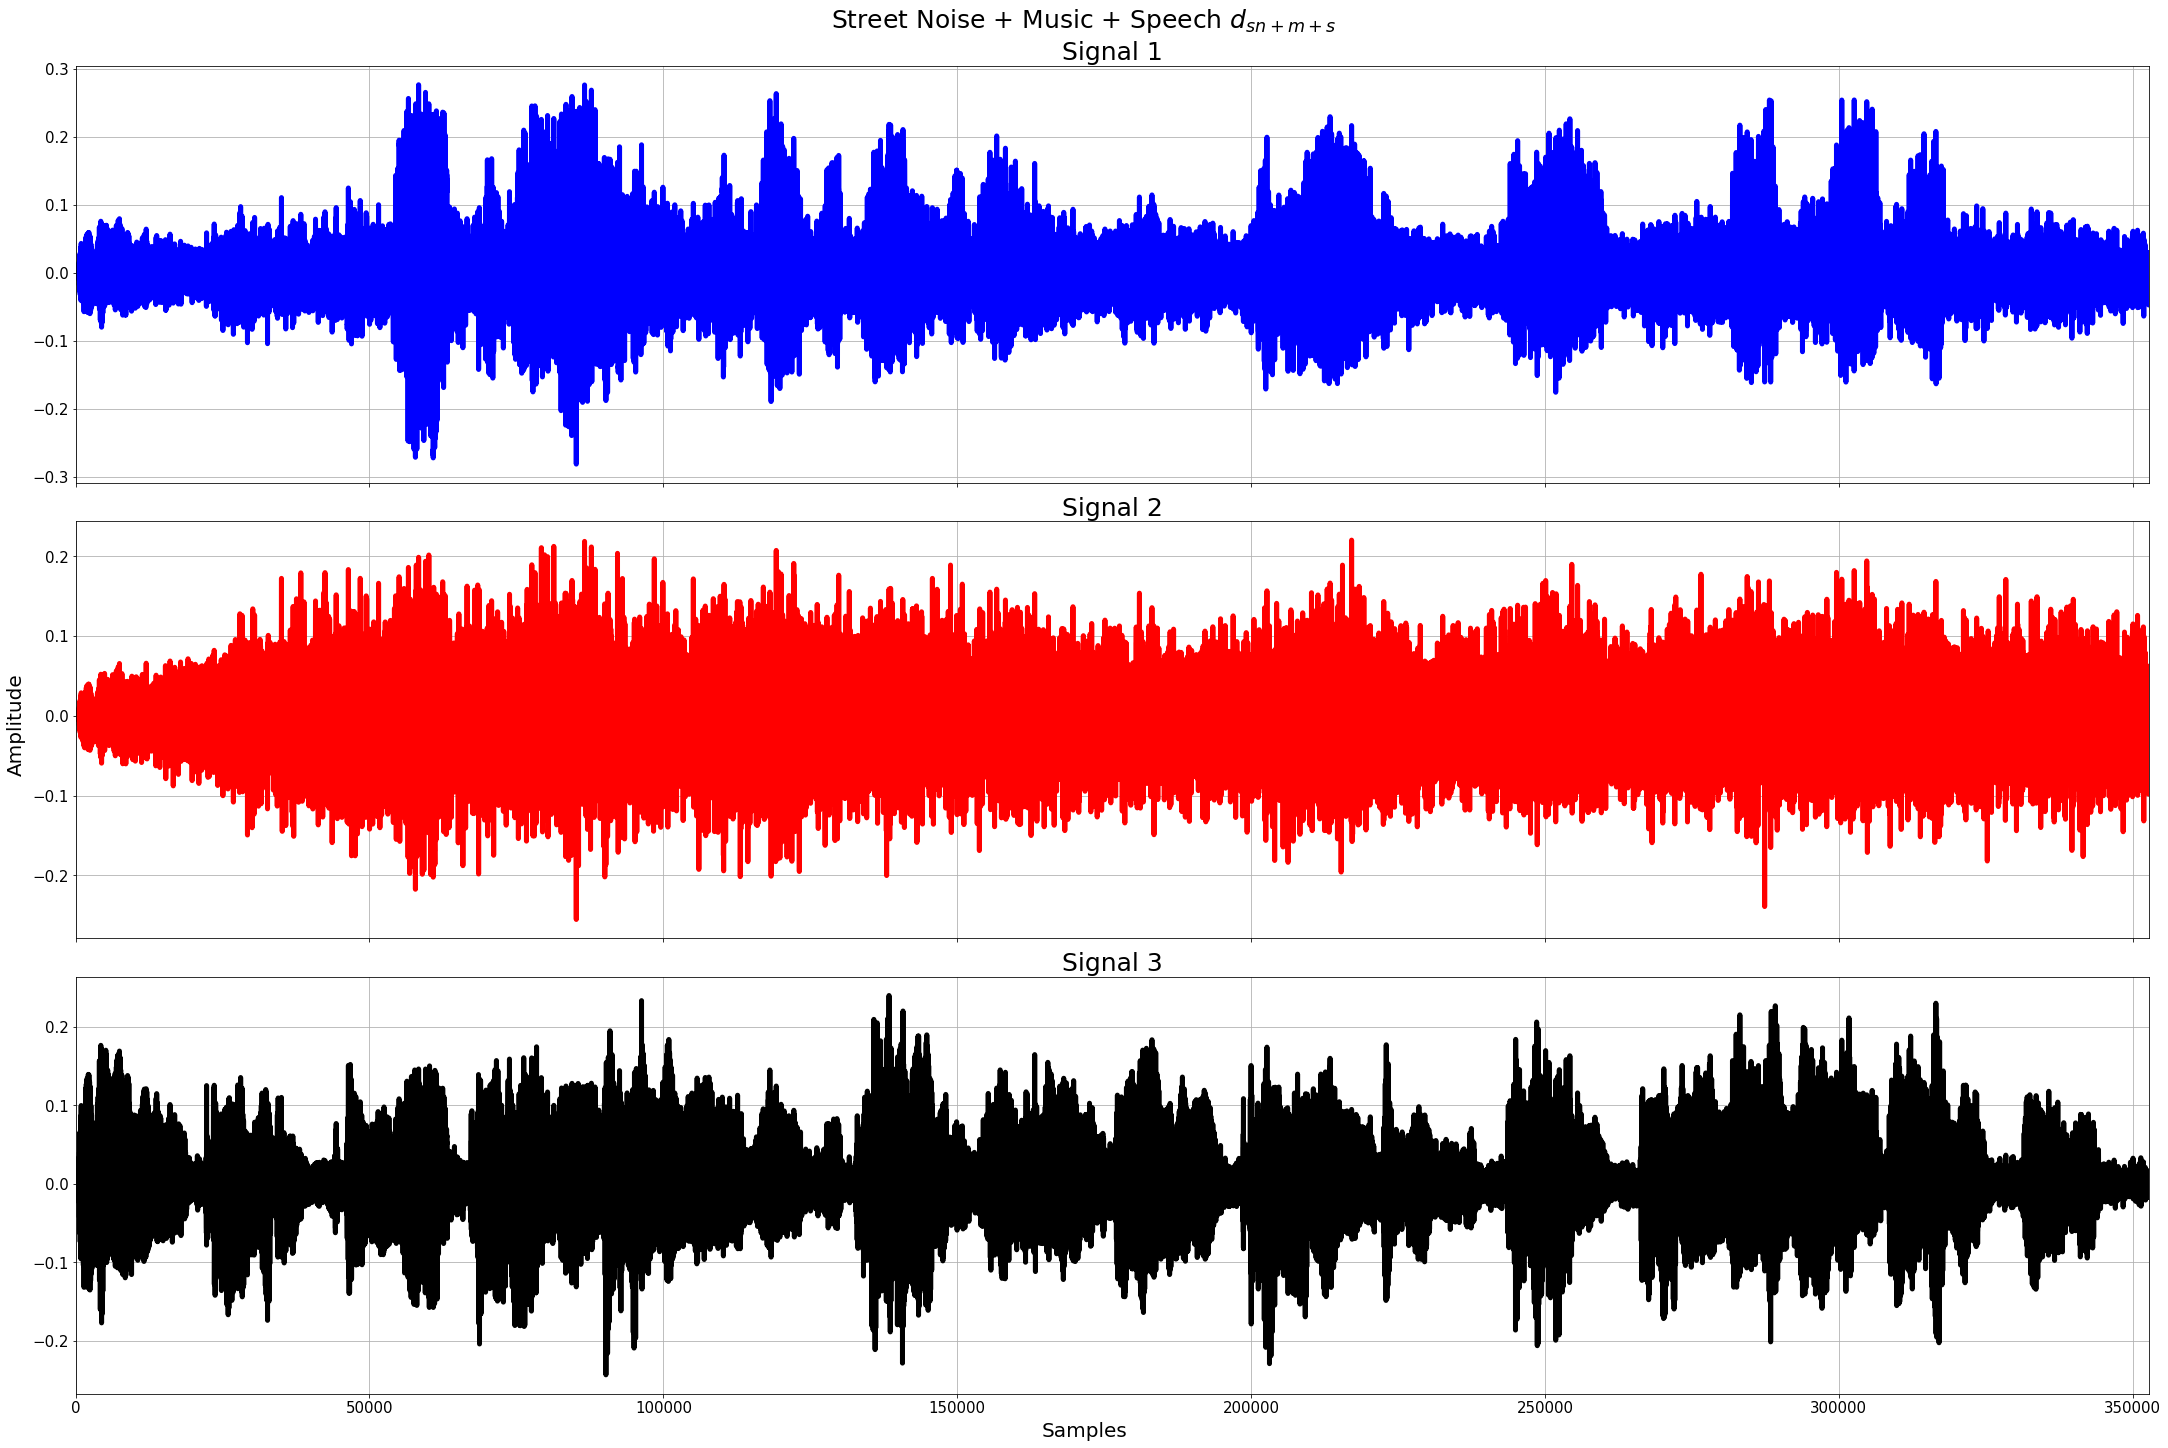

In [5]:
fig, axs = plt.subplots(3, 1, figsize=[30, 20], sharex=True, constrained_layout = True)
fig.supylabel('Amplitude', fontsize=20)
fig.supxlabel('Samples', fontsize=20)
fig.suptitle('Street Noise + Music + Speech $d_{sn+m+s}$', fontsize=25)

axs[0].plot(d_sn_m_s_1, lw=5, color='blue')
axs[0].set_title('Signal 1', fontsize=25)
axs[1].plot(d_sn_m_s_2, lw=5, color='red')
axs[1].set_title('Signal 2', fontsize=25)
axs[2].plot(d_sn_m_s_3, lw=5, color='black')
axs[2].set_title('Signal 3', fontsize=25)

for ax in axs: 
    ax.set_xlim(0, max_length)
    ax.tick_params(labelsize=15)
    ax.grid()

### Combine and Normalize Observations

In [6]:
observation = np.c_[d_sn_m_s_1, d_sn_m_s_2, d_sn_m_s_3]

observation /= observation.std(axis=0)

### Add Additional Distortion

In [7]:
add_distortion = False
if add_distortion:
    mixing = np.array([[0.5, 1, 0.2],
                        [1, 0.5, 0.4],
                        [0.5, 0.8, 1]])
                        
    observation = np.dot(true_signal, mixing.T) 

In [8]:
# Save ICA signal
def save_ica_audio(audio, name, folder):
    names_ica = []
    for ii in range(audio.shape[1]):
        names_ica.append('ica_{}_ch{}.wav'.format(name, ii+1))

    for ii, (name, sr) in enumerate(zip(names_ica, sample_rates)):
        sf.write(os.path.join(folder, name), audio[:,ii], sr)

### Apply FastICA

In [9]:
ica = FastICA()
ica_recovered = ica.fit_transform(observation) 

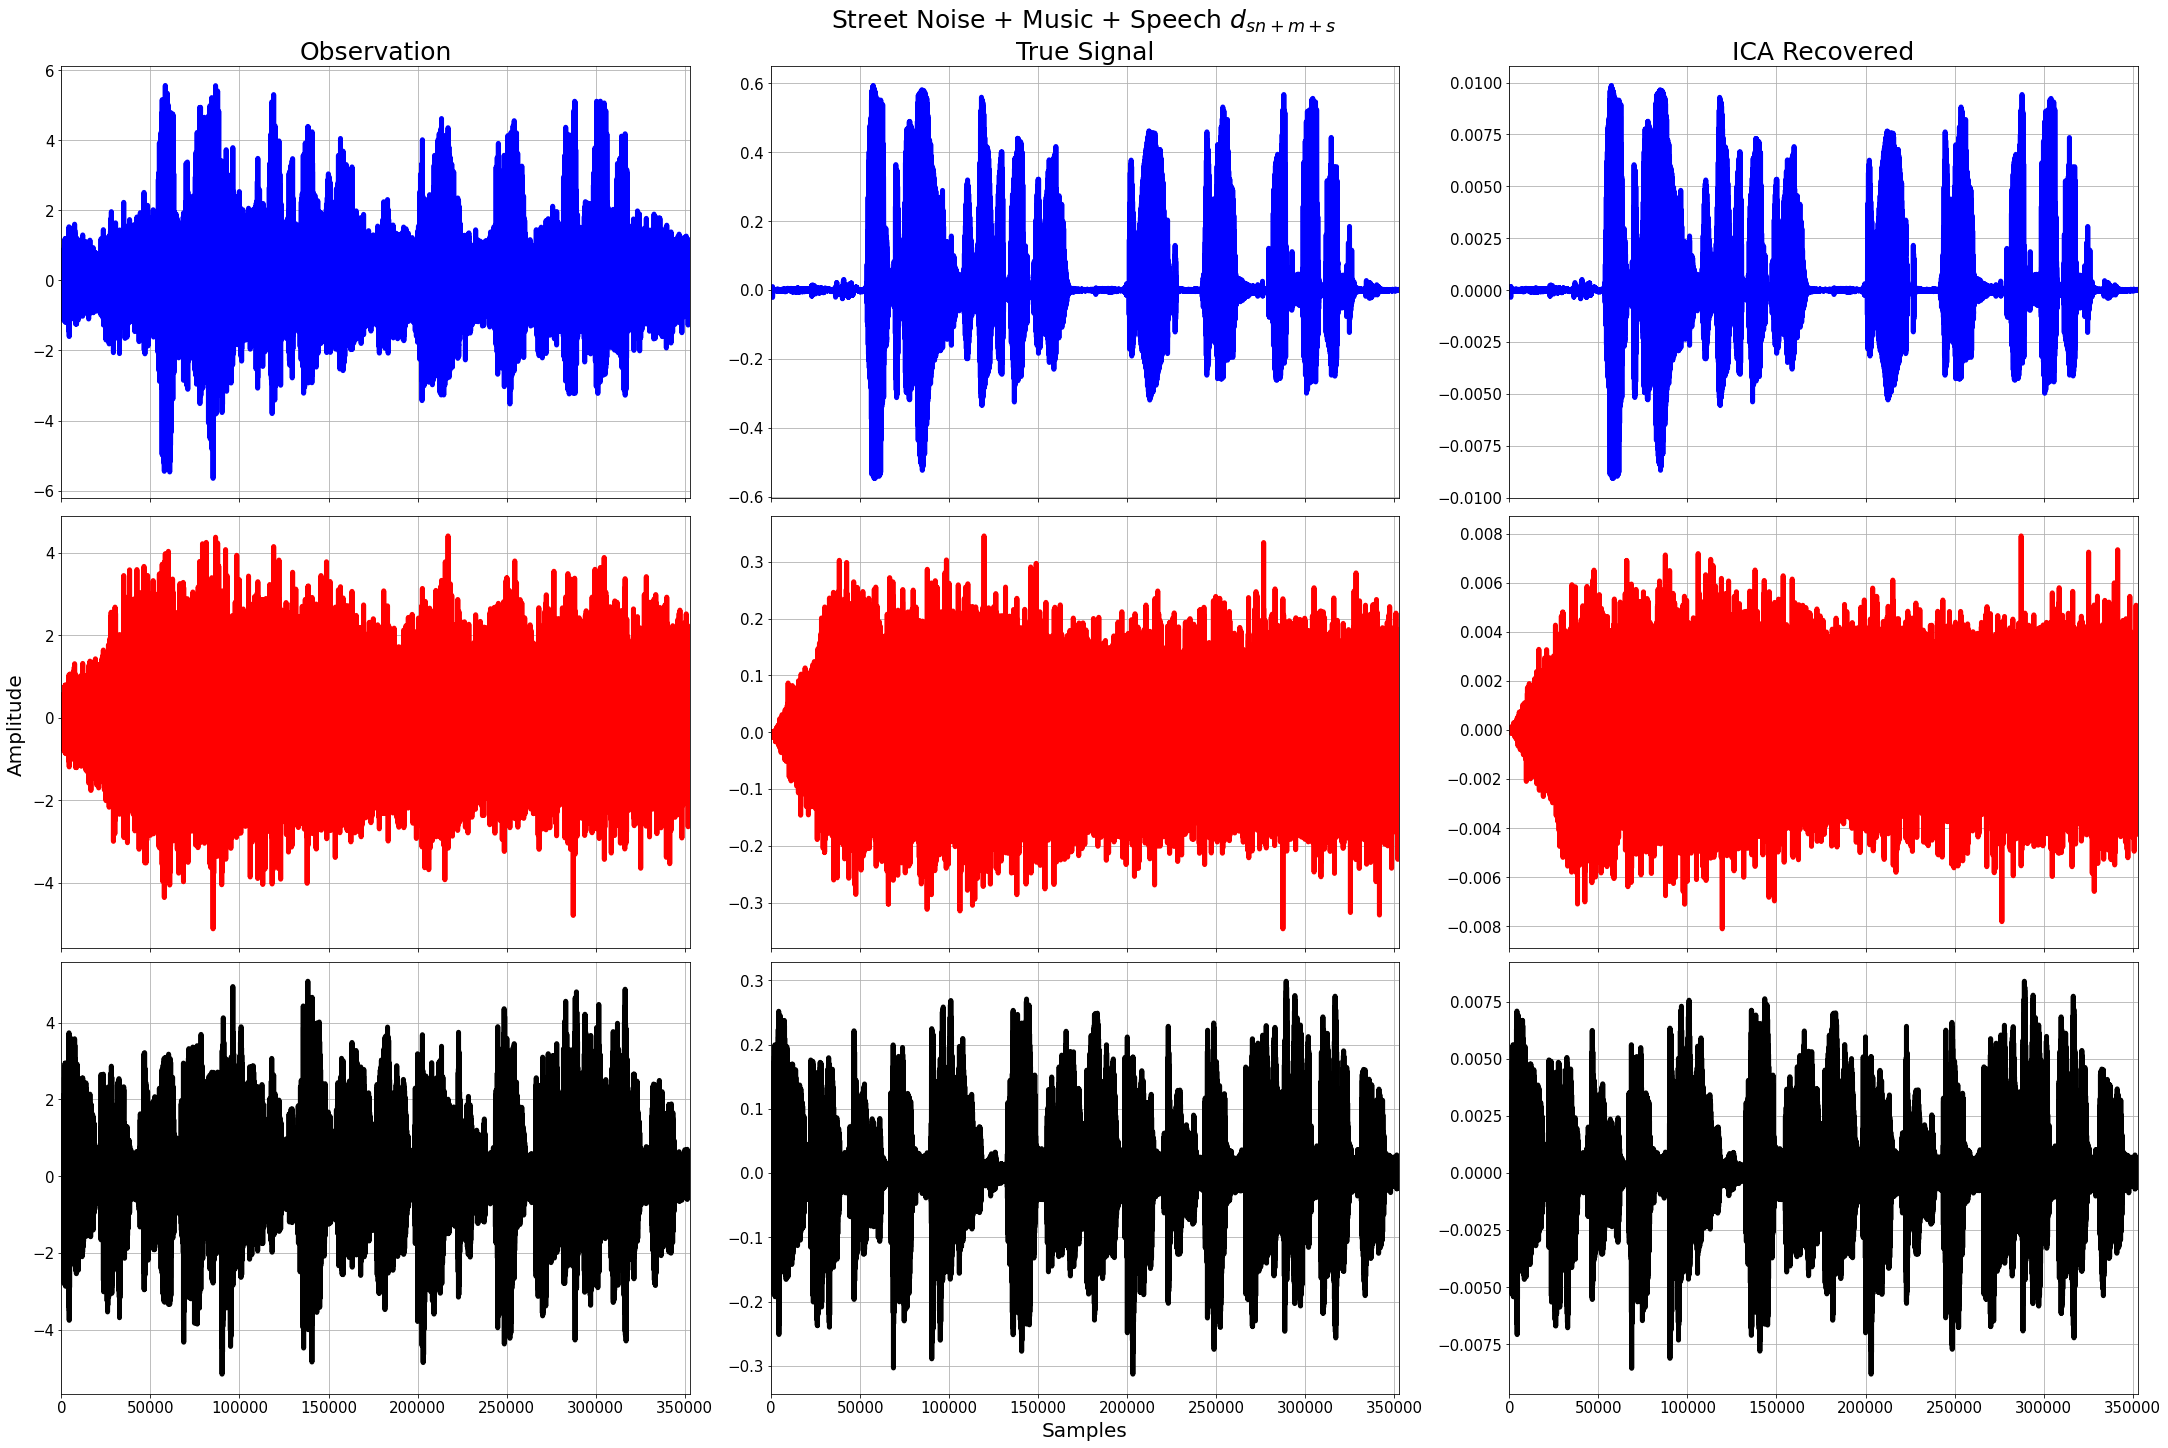

In [10]:
simple_plot = False
if simple_plot:
    fig, axs = plt.subplots(3, 1, figsize=[30, 20], sharex=True, constrained_layout = True)
    fig.supylabel('Amplitude', fontsize=20)
    fig.supxlabel('Samples', fontsize=20)
    fig.suptitle('Street Noise + Music + Speech $d_{sn+m+s}$', fontsize=25)
    
    axs[0].plot(ica_recovered[:, 0], lw=5, color='blue')
    axs[0].set_title('ICA Recovered', fontsize=25)
    axs[1].plot(ica_recovered[:, 1], lw=5, color='red')
    axs[2].plot(ica_recovered[:, 2], lw=5, color='black')

    for ax in axs: 
        ax.set_xlim(0, max_length)
        ax.tick_params(labelsize=15)
        ax.grid()
else:
    ica_lst = [observation, true_signal, ica_recovered]
    ica_name = ['Observation', 'True Signal', 'ICA Recovered']
    fig, axs = plt.subplots(3, 3, figsize=[30, 20], sharex=True, constrained_layout = True)
    fig.supylabel('Amplitude', fontsize=20)
    fig.supxlabel('Samples', fontsize=20)
    fig.suptitle('Street Noise + Music + Speech $d_{sn+m+s}$', fontsize=25)

    for ii, (data, name) in enumerate(zip(ica_lst, ica_name)):
        axs[0][ii].plot(data[:, 0], lw=5, color='blue')
        axs[0][ii].set_title(name, fontsize=25)
        axs[1][ii].plot(data[:, 1], lw=5, color='red')
        axs[2][ii].plot(data[:, 2], lw=5, color='black')

    for row in axs: 
        for ax in row: 
            ax.set_xlim(0, max_length)
            ax.tick_params(labelsize=15)
            ax.grid()

In [11]:
# Save observations and recovered signal
save_ica_audio(ica_recovered, 'recv_sig3', ica_folder)
save_ica_audio(observation, 'obsv_sig3', outp_folder)

# Perform ICA for the remaining test observations

In [12]:
def ica(true_sig, observation, signal_name, add_distort=False):
    true_sig /= true_sig.std(axis=0)
    observation /= observation.std(axis=0)

    if add_distort:
        mixing = np.array([[0.5, 1],
                            [0.8, 0.2]])
        observation = np.dot(true_sig, mixing.T)
        
    ica = FastICA()
    ica_recovered = ica.fit_transform(observation)

    ica_lst = [observation, true_sig, ica_recovered]
    ica_name = ['Observation', 'True Signal', 'ICA Recovered']
    fig, axs = plt.subplots(2, 3, figsize=[30, 20], sharex=True, constrained_layout = True)
    fig.supylabel('Amplitude', fontsize=20)
    fig.supxlabel('Samples', fontsize=20)

    save_ica_audio(ica_recovered, 'recv_{}'.format(signal_name), ica_folder)
    save_ica_audio(observation, 'obsv_{}'.format(signal_name), outp_folder)

    equalize_amp = False
    if equalize_amp:
        ratio = np.abs(true_sig).mean() / np.abs(ica_recovered).mean()
        for ii in range(ica_recovered.shape[1]):
            ica_recovered[:, ii] = ica_recovered[:, ii] * ratio
    
    for ii, (data, name) in enumerate(zip(ica_lst, ica_name)):
        axs[0][ii].plot(data[:, 0], lw=5, color='blue')
        axs[0][ii].set_title(name, fontsize=25)
        axs[1][ii].plot(data[:, 1], lw=5, color='red')

    for row in axs: 
        for ax in row: 
            ax.set_xlim(0, max_length)
            ax.tick_params(labelsize=15)
            ax.grid()



## Remaining Signals

In [13]:
# 1                 Music +             White Noise
d_m_wn_1 = 0.7 * audio_files[2] + 0.3 * audio_files[3]
d_m_wn_2 = 0.3 * audio_files[2] + 0.7 * audio_files[3]
observation_1 = np.c_[d_m_wn_1, d_m_wn_2]
true_signal_1 = np.c_[audio_files[2], audio_files[3]]
# 2                 Street +            Music
d_sn_m_1 = 0.7 * audio_files[1] + 0.3 * audio_files[2]
d_sn_m_2 = 0.3 * audio_files[1] + 0.7 * audio_files[2]
observation_2 = np.c_[d_sn_m_1, d_sn_m_2]
true_signal_2 = np.c_[audio_files[1], audio_files[2]]
# 4 :               Speech +            White Noise
d_s_wn_1 = 0.7 * audio_files[0] + 0.3 * audio_files[3]
d_s_wn_2 = 0.3 * audio_files[0] + 0.7 * audio_files[3]
observation_4 = np.c_[d_s_wn_1, d_s_wn_2]
true_signal_4 = np.c_[audio_files[0], audio_files[3]]

# Music + White Noise $d_{m+wn}$

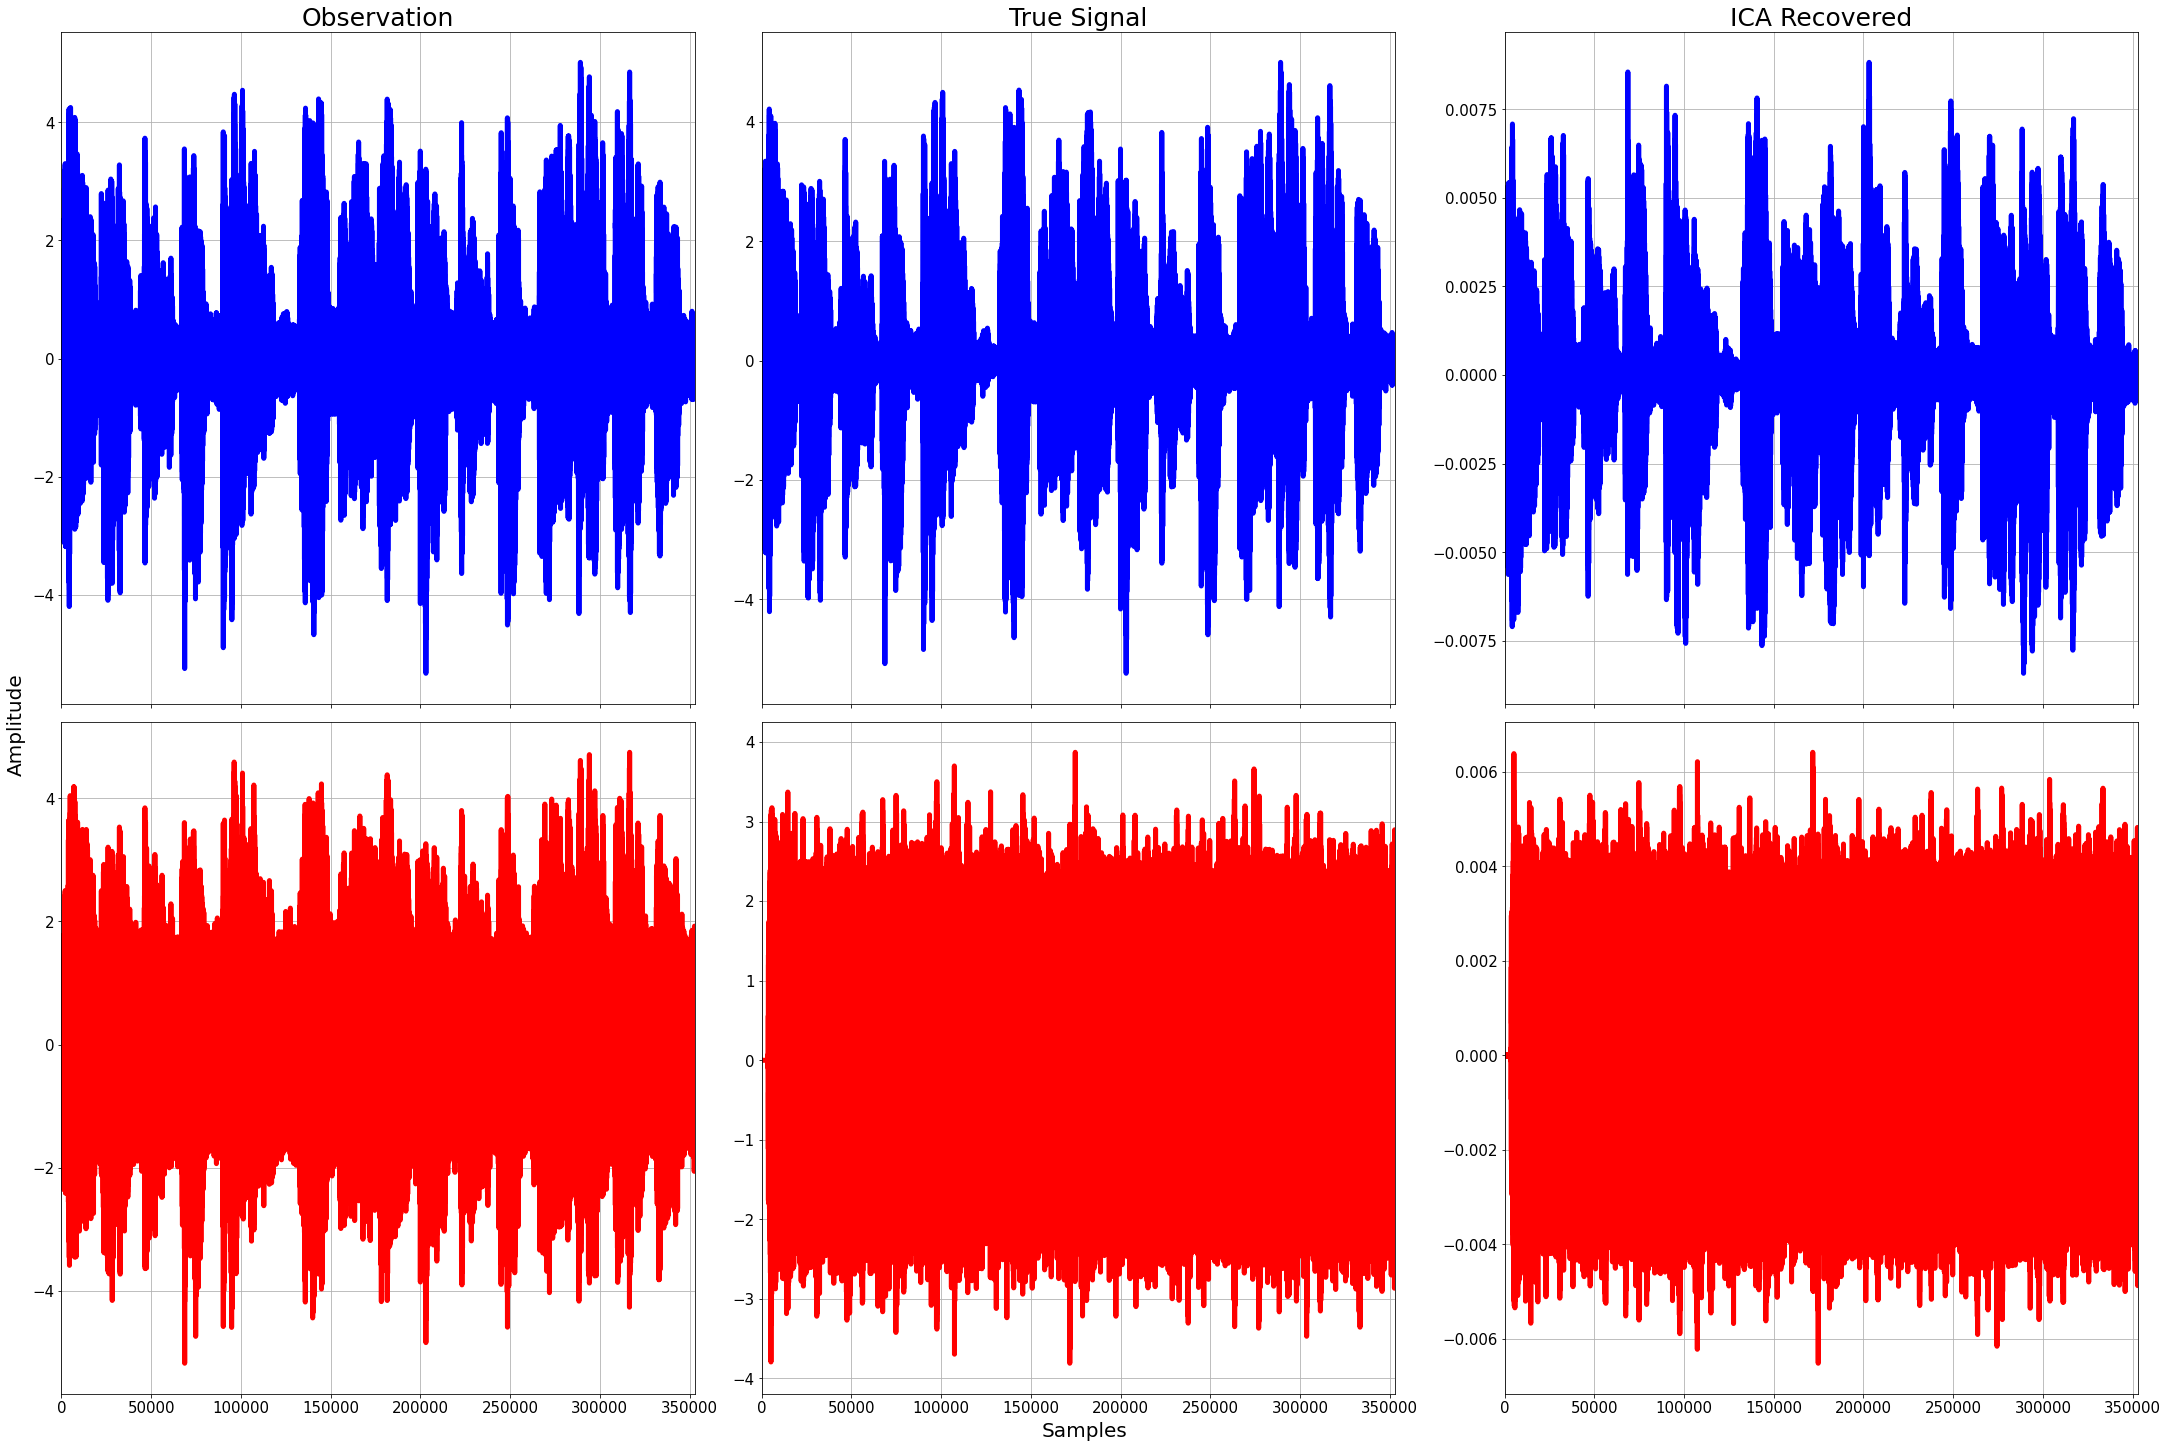

In [14]:
ica(true_signal_1, observation_1, 'sig1')

# Street Noise + Music $d_{sn+m}$

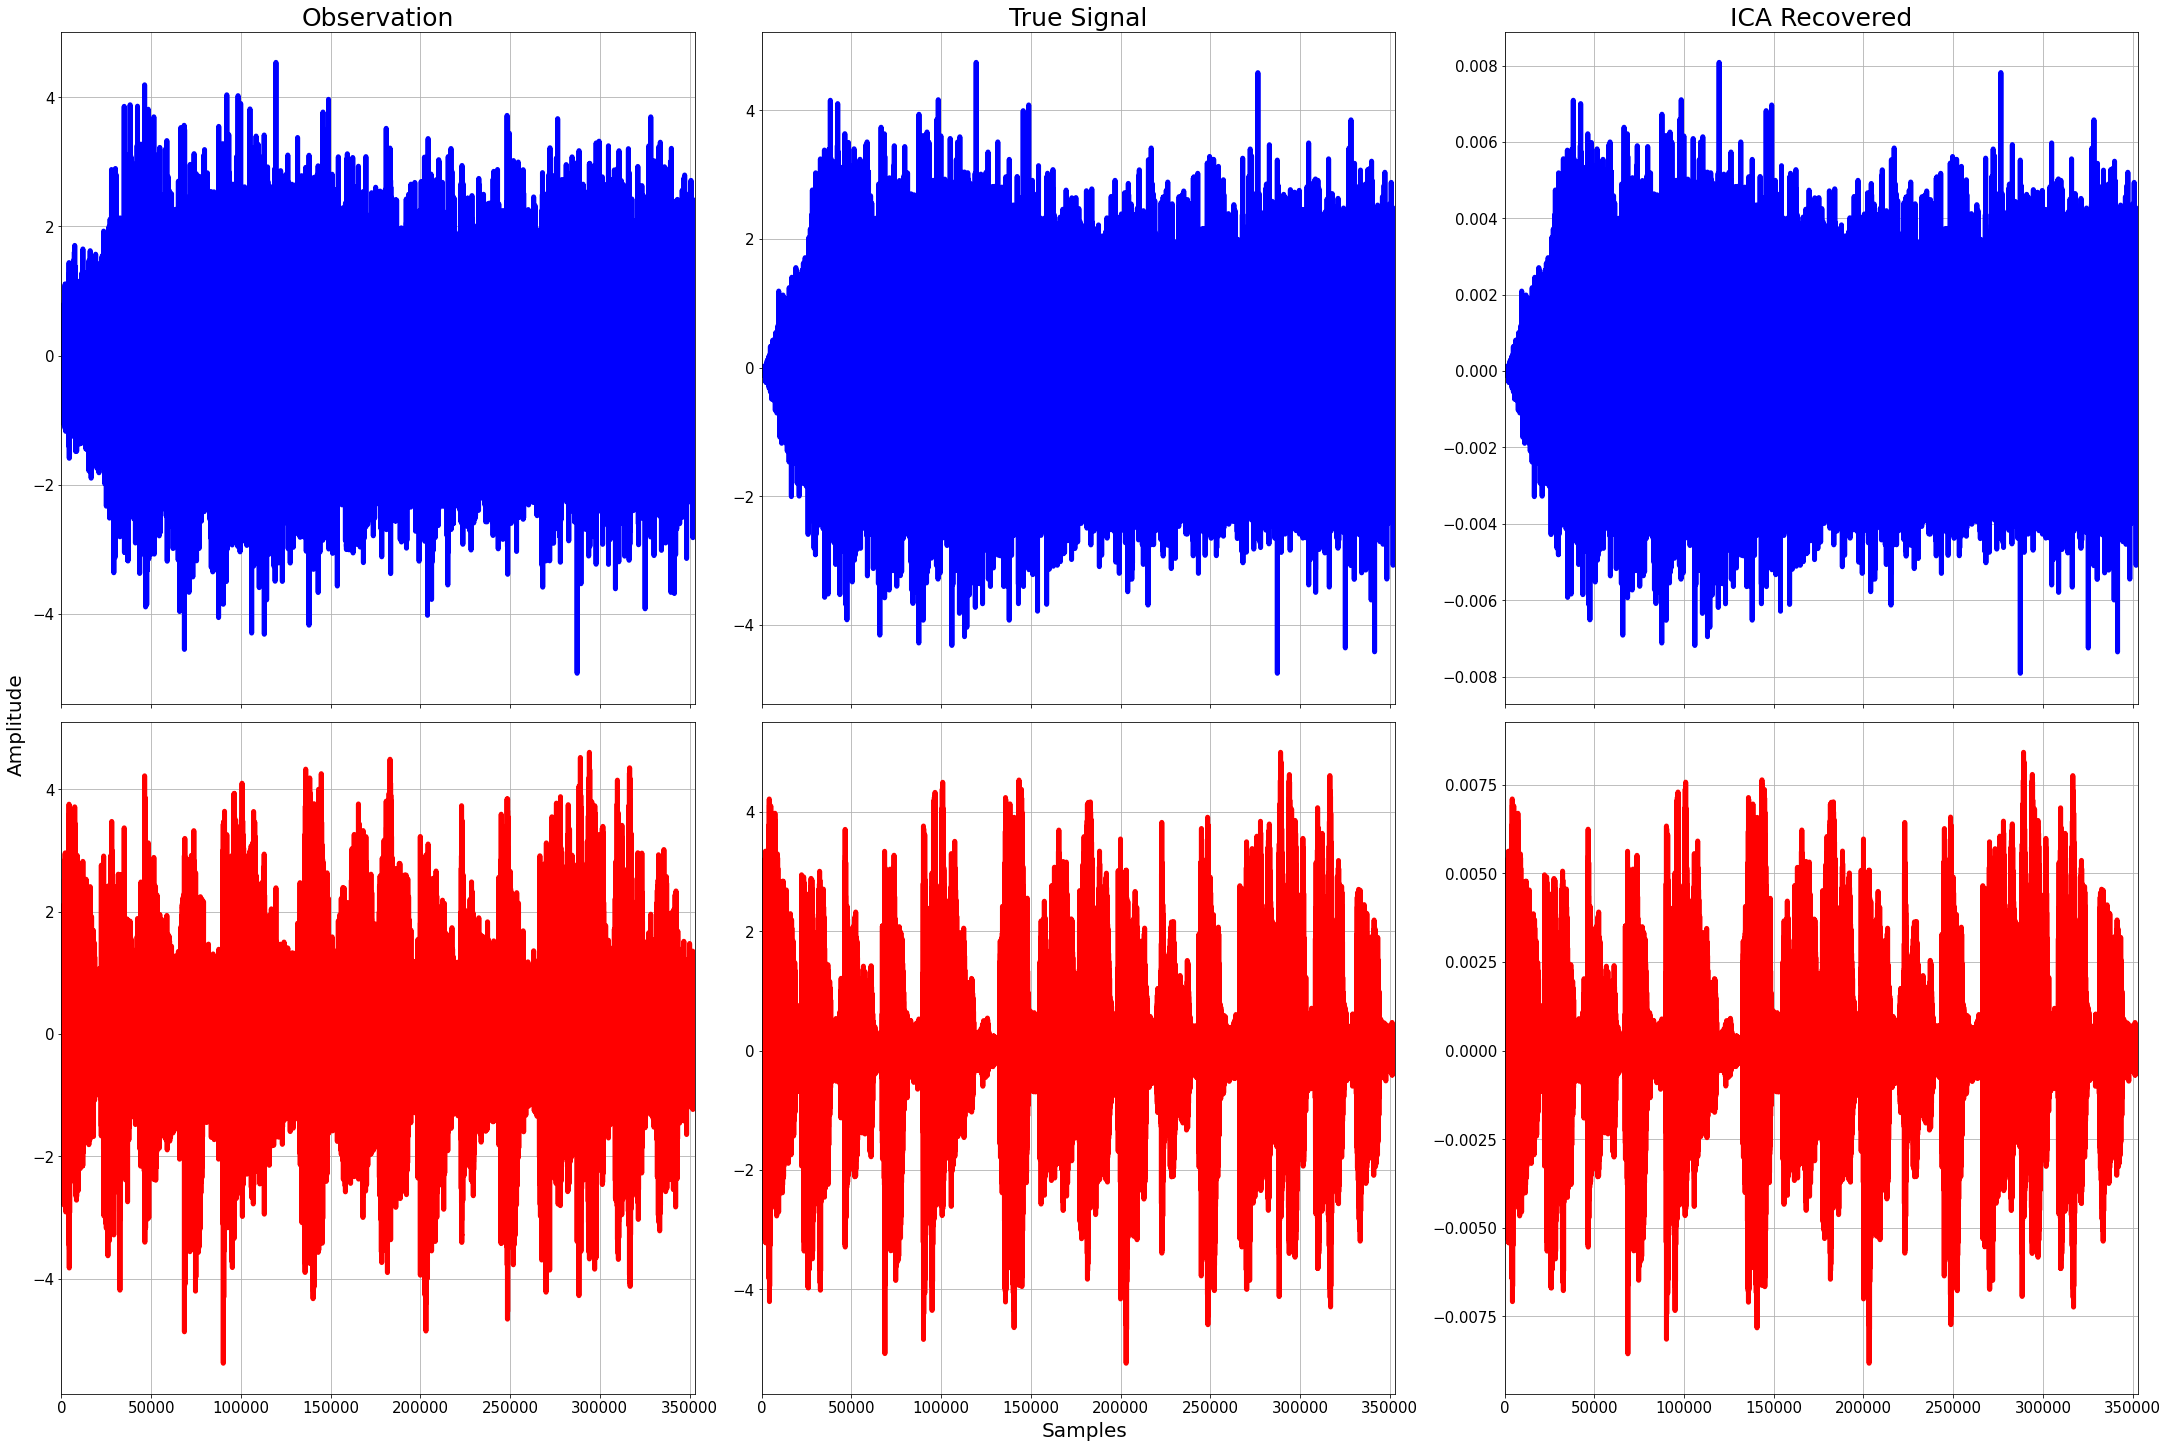

In [15]:
ica(true_signal_2, observation_2, 'sig2')